# Kaggle Pre-requisites

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mrobox7","key":"d9c279515ed368d033fca5bdc4ed1f6e"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Flickr Dataset 30k Images
!kaggle datasets download -d hsankesara/flickr-image-dataset

100% 8.16G/8.16G [06:21<00:00, 18.8MB/s]
100% 8.16G/8.16G [06:21<00:00, 23.0MB/s]


In [ ]:
# Flickr Dataset 8k Images
!kaggle datasets download -d adityajn105/flickr8k

 99% 1.03G/1.04G [00:04<00:00, 214MB/s]
100% 1.04G/1.04G [00:05<00:00, 220MB/s]


In [6]:
!unzip flickr-image-dataset
# !unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5354911151.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536156200.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/

# Importing Libraries/Model

In [7]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils.image_utils import load_img, img_to_array
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.utils import to_categorical, plot_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [8]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
INPUT_DIR = "/content/flickr30k_images/"
OUTPUT_DIR = "/content/Output"

# Image Feature Extraction

In [ ]:
# extract features from image
features = {}
directory = os.path.join(INPUT_DIR, 'flickr30k_images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/31785 [00:00<?, ?it/s]

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(OUTPUT_DIR, 'features.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join(OUTPUT_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

# Caption Data

In [5]:
captions_doc = open("/content/flickr30k_images/captions.csv", 'r', encoding='utf-8').read()

In [10]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/158916 [00:00<?, ?it/s]

# Text Processing

In [11]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [12]:
clean(mapping)

In [13]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [14]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [16]:
pickle.dump(tokenizer, open(os.path.join(OUTPUT_DIR, 'vocab.pkl'), 'wb'))

In [17]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)

# Validation Data Split

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# Model

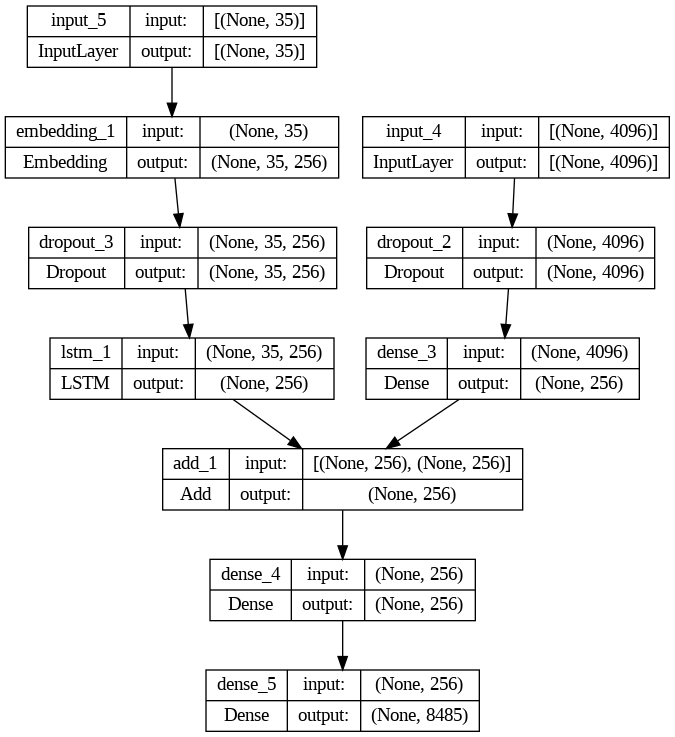

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 66s 289ms/step - loss: 2.1834


In [ ]:
# save the model
model.save(OUTPUT_DIR+'/model.h5',include_optimizer=True)

# Caption Generation

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/256 [00:00<?, ?it/s]

KeyError: ignored

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(INPUT_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)